---
title: "Analysis of Hyper-parameters on Single Cell RNA-Seq Data"
format:
    html:
        toc: true
        highlight-style: ayu
---

In [67]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import silhouette_score, silhouette_samples
import scanpy as sc
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.figure_factory as ff


## Getting the Data

We will analyze three types of hyper-parameters: Perplexity on t-SNE, number of clusters chosen from an unsupervised method and how these affect the quality of the selected features and the type of regularization.

To performs these three tasks we are gonna work with real data. Specifically, we're gonna use scRNA-Seq data from a brain sample (GSM6900730). The data is available on https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM6900730.  

In [68]:
# download the data and load it for the posterior analysis
import urllib.parse
import requests
import urllib
from bs4 import BeautifulSoup
import os
from ftplib import FTP

url = "https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM6900730"

response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table')
links = table.find_all('a')

download_dir = os.getcwd()

for link in links:
    # Get the URL of the link
    link_url = link.get('href')
    # Check if the link contains 'ftp'
    if link_url and 'ftp' in link_url:
        # Parse the FTP URL
        link_url = urllib.parse.unquote(link_url)
        parsed_url = urllib.parse.urlparse(link_url)
        hostname = parsed_url.hostname
        path = parsed_url.path
        
        # Connect to the FTP server
        ftp = FTP(hostname)
        ftp.login()
        ftp.cwd(os.path.dirname(path))
    
        # Extract the file name from the path
        file_name = os.path.basename(path)
        local_file_path = os.path.join(download_dir, file_name)
        
        with open(local_file_path, "wb") as local_file:
            ftp.retrbinary(f"RETR {file_name}", local_file.write)
    
        ftp.quit()
        print(f"Downloaded {file_name}")
        


Downloaded GSM6900730_JLE16_B1_barcodes.tsv.gz
Downloaded GSM6900730_JLE16_B1_features.tsv.gz
Downloaded GSM6900730_JLE16_B1_matrix.mtx.gz


Now, let's load the data (is a sparse matrix) with `scanpy`:

In [75]:
scdata = sc.read_10x_mtx('D:/Data Analysis Statistical Modeling and Computation in Applications/data/scrnaseq data/',
                         var_names = 'gene_symbols',
                         cache=False)

X_sc = scdata.X.toarray()
print(X_sc.shape)

(5154, 36601)


Ok, now we are gonna tranform the data with (`log(x+1)`) due to the presence of genes with extremely high magnitudes of expression in only a few cells.

In [74]:
X_sc_transformed = np.log2(X_sc + 1)

We can use the principal components analysis to get the top components that explains the 85% variability of the data.

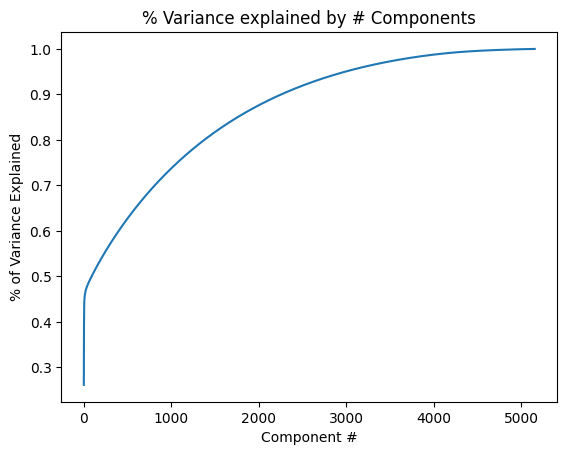

Variance explained 85%: 1758


In [76]:
# PCA

pca = PCA()
pca_axes = pca.fit_transform(X_sc_transformed)


csum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(0,X_sc_transformed.shape[0]),csum)
plt.xlabel('Component #')
plt.ylabel('% of Variance Explained')
plt.title('% Variance explained by # Components')
plt.show()

print(f'Variance explained 85%: {np.where(csum >= 0.85)[0][0]}')


Let's save the number of components on a variable.

In [78]:
top_pca_components = np.where(csum >= 0.85)[0][0]

### Analysis of Perplexities

For the first part of the analysis, we are gonna analyze the following perplexities: 10,20,30,40,50 and see how this change the output of the t-SNE analysis. 

In [80]:
# let's write a helper function for the tsne

def tsne_plotter(data=None,per=40):

    tsne = TSNE(n_components=2, perplexity=per)

    x_tsne = tsne.fit_transform(data)

    ax.scatter(x_tsne[:, 0], x_tsne[:, 1])
    ax.set_xlabel('tSNE 1')
    ax.set_ylabel('tSNE 2')
    ax.set_title(f't-SNE Plot for log2\nTransformed Data, Perplexity:{per}')


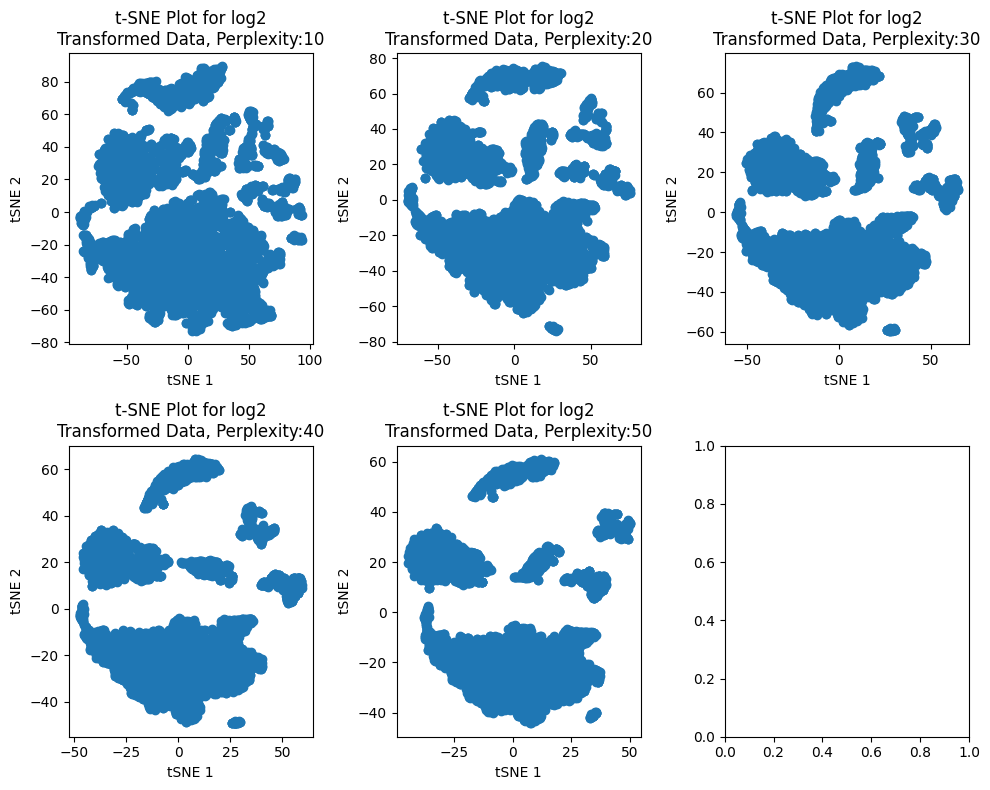

In [81]:
perplexities = [10,20,30,40,50]

num_plots = len(perplexities)
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10,8))

for i,perplexity in enumerate(perplexities):

    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    tsne_plotter(pca_axes[:,0:50], per= perplexity)

plt.tight_layout()
plt.show()